## March Madness Logistic Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002_2019_update.csv')

In [4]:
mm_data.columns.tolist()

['team1_id',
 'team1_score',
 'team2_id',
 'team2_score',
 'WLoc',
 'num_ot',
 'team1_position',
 'team2_position',
 'team1_seed',
 'team2_seed',
 'strongseed',
 'weakseed',
 'team1_region',
 'team2_region',
 'slot',
 'team1_teamname',
 'team2_teamname',
 'season',
 'host',
 'host_lat',
 'host_long',
 'team1_lat',
 'team1_long',
 'team2_lat',
 'team2_long',
 'team1_coach_id',
 'team1_pt_school_ncaa',
 'team1_pt_overall_ncaa',
 'team1_pt_school_s16',
 'team1_pt_overall_s16',
 'team1_pt_school_ff',
 'team1_pt_overall_ff',
 'team1_pt_career_school_wins',
 'team1_pt_career_school_losses',
 'team1_pt_career_overall_wins',
 'team1_pt_career_overall_losses',
 'team1_pt_team_season_wins',
 'team1_pt_team_season_losses',
 'team1_pt_coach_season_wins',
 'team1_pt_coach_season_losses',
 'team2_coach_id',
 'team2_pt_school_ncaa',
 'team2_pt_overall_ncaa',
 'team2_pt_school_s16',
 'team2_pt_overall_s16',
 'team2_pt_school_ff',
 'team2_pt_overall_ff',
 'team2_pt_career_school_wins',
 'team2_pt_caree

In [5]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [7]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

## Log 5
P(W) = (A - A * B) / (A + B - 2*A*B)

In [8]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [9]:
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,106.296,F Dickinson,2019,Prairie View,110.5500,0.389061,0.382990,0.506403
1,114.952,Belmont,2019,Temple,101.8860,0.800207,0.738939,0.585922
2,106.675,N Dakota St,2019,NC Central,109.8730,0.415885,0.208404,0.730051
3,109.886,Arizona St,2019,St John's,98.6844,0.774944,0.721882,0.570190
4,110.803,Minnesota,2019,Louisville,96.3335,0.833312,0.913200,0.322116


## Seed Diff

In [10]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [11]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id
0,2019-1192.0-1341.0,0.389061,0.382990,76,82,-648.033425,0.506403,1192.0,1341.0
1,2019-1125.0-1396.0,0.800207,0.738939,70,81,-307.876634,0.585922,1125.0,1396.0
2,2019-1295.0-1300.0,0.415885,0.208404,74,78,663.316546,0.730051,1295.0,1300.0
3,2019-1113.0-1385.0,0.774944,0.721882,65,74,1676.167033,0.570190,1113.0,1385.0
4,2019-1278.0-1257.0,0.833312,0.913200,76,86,-391.001293,0.322116,1278.0,1257.0


## Split Data

In [12]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [13]:
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [14]:
np.random.seed(0)

def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)
random_indices = random.sample(range(len(mm_data)), int(len(mm_data)/2))

In [15]:
mm_data_1 = mm_data[~mm_data.index.isin(random_indices)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                                      'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(random_indices)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].reset_index(drop=True)

In [16]:
mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data['seed_diff'] = mm_data['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff']

In [17]:
mm_train = pd.concat([mm_data_2, mm_data_1])

In [18]:
mm_data_2019 = mm_train[mm_train['season'] == 2019].reset_index(drop=True)
mm_data_else =  mm_train[mm_train['season'] != 2019].reset_index(drop=True)

## Initial Check

In [19]:
mm_data_else.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.373595
1    0.613930
Name: team1_log5, dtype: float64

In [20]:
mm_data_else.groupby('team1_win')['seed_diff'].mean()

team1_win
0   -3.828210
1   -3.522852
Name: seed_diff, dtype: float64

In [21]:
mm_data_else.groupby('team1_win')['diff_dist'].mean()

team1_win
0    144.185589
1   -285.362580
Name: diff_dist, dtype: float64

## Train Logit

In [22]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else['team1_log5']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.669721
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1100
Model:                          Logit   Df Residuals:                     1099
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                 0.03378
Time:                        08:54:28   Log-Likelihood:                -736.69
converged:                       True   LL-Null:                       -762.45
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     0.8082      0.115      7.040      0.000       0.583       1.033
==============================================================================
"""

In [24]:
mm_data_2019['prob'] = logit.predict_proba(scaler.fit_transform(mm_data_2019[['team1_log5']]))[:,1]
mm_data_2019['prediction'] = logit.predict(scaler.fit_transform(mm_data_2019[['team1_log5']]))

In [25]:
mm_data_2019[['team1_log5','team1_win','prob','prediction']].head()

,team1_log5,team1_win,prob,prediction
0,0.414078,0,0.361267,0
1,0.316852,0,0.261896,0
2,0.198387,0,0.167387,0
3,0.543720,0,0.512961,1
4,0.470417,0,0.425636,0


In [26]:
mm_data_2019.groupby('team1_win')['prob'].mean()

team1_win
0    0.321352
1    0.640086
Name: prob, dtype: float64

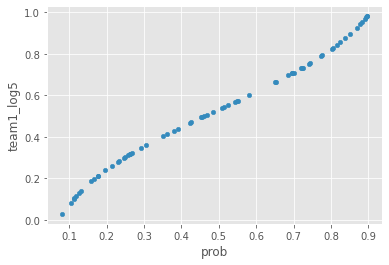

In [27]:
mm_data_2019.plot(kind='scatter', x='prob',y='team1_log5')

In [28]:
confusion_matrix(mm_data_2019['team1_win'], mm_data_2019['prediction'])

array([[22,  8],
       [12, 25]])

In [29]:
accuracy_score(mm_data_2019['team1_win'], mm_data_2019['prediction'],)

0.7014925373134329

In [30]:
precision_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.7575757575757576

In [31]:
recall_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.6756756756756757

In [32]:
f1_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.7142857142857142

In [33]:
log_loss(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)

0.487056730563625

In [34]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

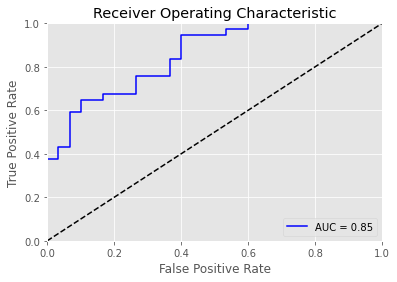

In [35]:
fpr, tpr, thresholds = roc_curve(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [36]:
roc_auc_score(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)

0.8522522522522522

## Add Seed Difference & Distance

In [37]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5','diff_dist','seed_diff']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else[['team1_log5','diff_dist','seed_diff']]).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.651548
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1100
Model:                          Logit   Df Residuals:                     1097
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                 0.06000
Time:                        08:54:28   Log-Likelihood:                -716.70
converged:                       True   LL-Null:                       -762.45
Covariance Type:            nonrobust   LLR p-value:                 1.361e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     0.9565      0.132      7.265      0.000       0.698       1.215
diff_dist     -0.0002   5.44e-05     -4.566      0.000      -0.000      -0.000
seed_diff      0.0375      0.009      3.971      0.000       0.019       0.056
==============================================================================
"""

In [39]:
mm_data_2019['prob'] = logit.predict_proba(scaler.fit_transform(mm_data_2019[['team1_log5','diff_dist','seed_diff']]))[:,1]
mm_data_2019['prediction'] = logit.predict(scaler.fit_transform(mm_data_2019[['team1_log5','diff_dist','seed_diff']]))

In [40]:
accuracy_score(mm_data_2019['team1_win'], mm_data_2019['prediction'],)

0.7313432835820896

In [41]:
precision_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.7878787878787878

In [42]:
recall_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.7027027027027027

In [43]:
f1_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.7428571428571429

In [44]:
log_loss(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)

0.479138581704498

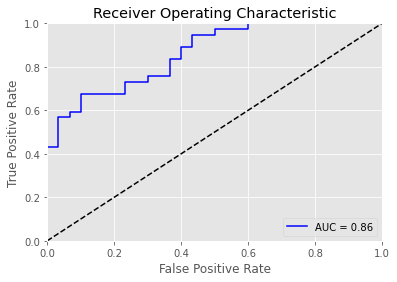

In [45]:
fpr, tpr, thresholds = roc_curve(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [46]:
roc_auc_score(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)

0.8603603603603603

## Create Example Submission

In [47]:
mm_data_2019[['game_id','prob']].head()

,game_id,prob
0,2019-1125.0-1396.0,0.362826
1,2019-1459.0-1371.0,0.255110
2,2019-1242.0-1318.0,0.149305
3,2019-1124.0-1393.0,0.485186
4,2019-1328.0-1279.0,0.432957


In [48]:
mm_data_2019['prob'] = .5

In [49]:
mm_data_2019[['game_id','prob']].to_csv("example_submission.csv", index=False)